## 1. Preparation

In [1]:
# Importing moduls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [2]:
# Reading our dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
display(df_train.head())
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# We check the data for gaps
pd.DataFrame(data = [df_train.isna().sum()/df_train.shape[0]*100, 
                     df_test.isna().sum()/df_test.shape[0]*100], 
             index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


We can see that Age and Cabin variable has quite a lot of null values in both train and test data. Embarked variable in train data has 2 null values, and Fare variable in test data has 1 null value. We will need to analyze this data first to decide whether to drop this column or do some imputation.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 12 variables, and each variable has 891 records. The types of variables in this dataset are as follows:
Numerical:
-Discrete:
+SibSp
+Parch
-Continous:
+Age
+Fare

Categorical:
-Nominal:
+Sex
+Embarked
+Survived (Target Variable)
-Ordinal:
+Pclass

Others:
-Text
+Ticket
+Name
-ID:
+PassengerId


## 2. Exploratory Data Analysis
Let's group our variable types and make two functions to visualize our numerical and categorical data first.

In [5]:
num_var = ["SibSp", "Parch", "Age", "Fare"]
cat_var = ["Sex", "Embarked", "Pclass"]
target = "Survived"

In [6]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()
    
def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df_train[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=df_train, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

### Checking Predictor Distribution

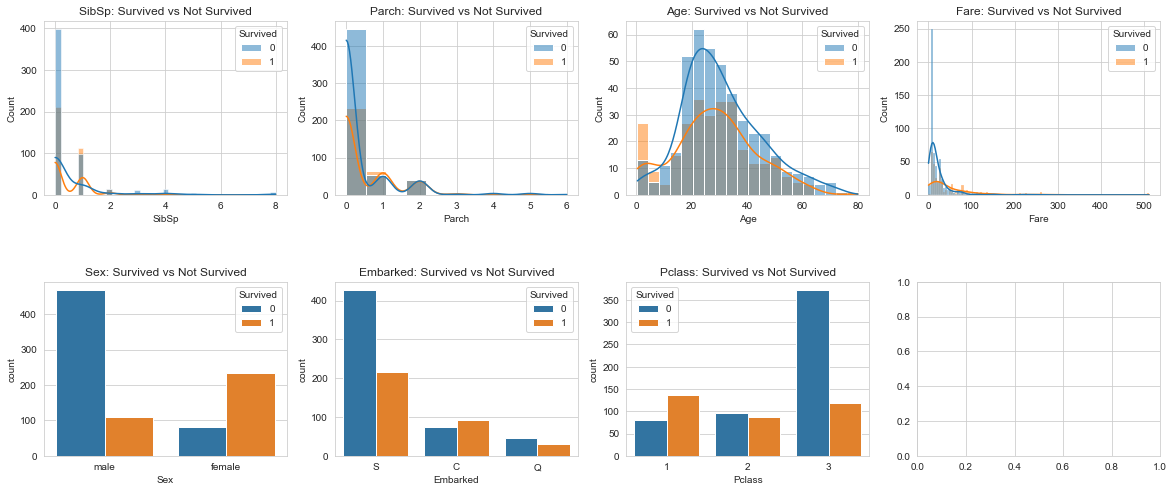

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.flatten()

for i, var in enumerate(num_var+cat_var):
    if i < 4:
        sns.histplot(data=df_train, x=var, hue=target, kde=True, ax=ax[i])
    else:
        sns.countplot(data=df_train, x=var, hue=target, ax=ax[i])
    
    ax[i].set_title(f"{var}: Survived vs Not Survived")
    
plt.subplots_adjust(hspace=0.5)
plt.show()

Apparently, passengers who travel with small numbers of family have a greater survival chance. Also, large number of children (Age <= 10) survived in this tragedy, while passengers with the age above them tend not to survive. We can also see the number of female who survived was much more than male (women and children first code). Passengers embarked from port C seem to be luckier as many of them survived. Pclass also plays quite a role here because most of the passengers from Pclass 1 managed to survive or have more priority to be saved, while passengers with Pclass 3 tend not to survive.

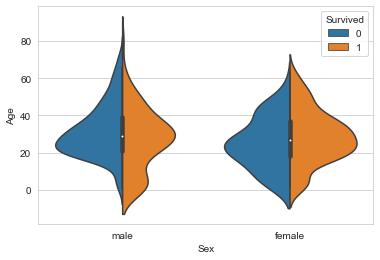

In [8]:
sns.violinplot(data=df_train, x="Sex", y="Age", hue="Survived", split=True)
plt.show()

Children survival rate for both gender seems to be good, even though the survival rate for boys is higher. For old people (Age > 60), the survival rate for old men tends to be lower, in contrast to the survival rate for old women which tends to be higher.

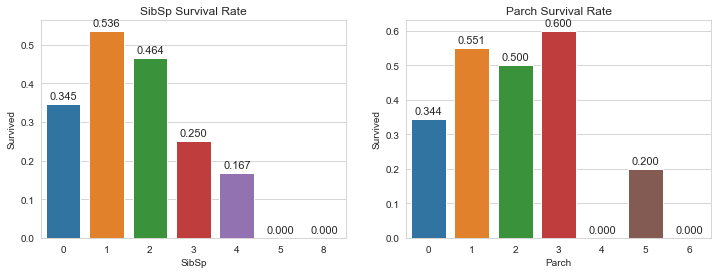

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, var in enumerate(["SibSp", "Parch"]):
    surv = sns.barplot(data=df_train, x=var, y=target, ax=ax[i], ci=None)
    for bar in surv.patches:
        surv.annotate(format("{:.3f}".format(bar.get_height())),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
        
    ax[i].set_title(f"{var} Survival Rate")

The graph above shows that passengers with small numbers of family tend to survive. Meanwhile, there are only ~34% of the lone passengers (SibSpb and Parch = 0) who survived. Unfortunately, 0% passengers with SibSp > 4 survived, and almost no passengers with Parch > 3 survived.

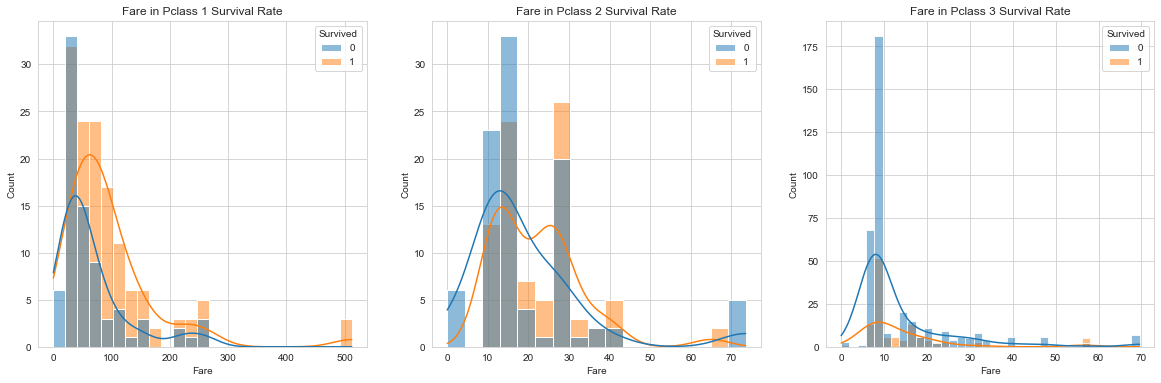

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, pc in enumerate(sorted(df_train["Pclass"].unique())):
    sns.histplot(data=df_train[df_train["Pclass"]==pc], x="Fare", hue=target, kde=True, ax=ax[i])
    ax[i].set_title(f"Fare in Pclass {pc} Survival Rate")

Passengers with higher fares are more likely to survive these accidents, although some of those with the highest fares on the Pclass 2 didn't survive. Even though most of the passengers who didn't survive were those with Pclass 3, but Pclass 1 and 2 also did not guarantee passenger safety, especially for those with less fares.

## 3. Feature Engineering

In [11]:
df_train.drop("PassengerId", axis=1, inplace=True)
df_test.drop("PassengerId", axis=1, inplace=True)

In [12]:
df_train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

As we can see, there is a pattern in the names of the passengers that we can extract, which is their title (Mr, Mrs, Miss, etc.). Let's extract the string value followed by dot (.).

In [13]:
df_train["Title"] = df_train["Name"].str.extract('([A-Za-z]+)\.')
df_test["Title"] = df_test["Name"].str.extract('([A-Za-z]+)\.')

df_train["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

Some initials are owned by very few people, and some initials have the same meaning as others. We will group them according to the proper group.



In [14]:
def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Other"
        
df_train["Title"] = df_train["Title"].map(convert_title)
df_test["Title"] = df_test["Title"].map(convert_title)

df_train["Title"].value_counts()

Mr        517
Miss      183
Mrs       126
Master     40
Other      25
Name: Title, dtype: int64

We've got the initials of each passenger, so now the variable name is no longer needed. We can remove this variable now.



In [15]:
df_train.drop("Name", axis=1, inplace=True)
df_test.drop("Name", axis=1, inplace=True)

In [16]:
df_train["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

This variable also only contains the unique ticket value for each passenger, and there is no pattern that we can extract. So, we'll just remove this variable.



In [17]:
df_train.drop("Ticket", axis=1, inplace=True)
df_test.drop("Ticket", axis=1, inplace=True)

Next variable has too many missing values in both train and test data (more than 77%), so this variable is missing a lot of information. We will also remove this variable.



In [18]:
df_train.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

The age variable has a missing value of 19.87% in the training data and 20.57% in the test data. That number is not really much, so we will try to do data imputation on this variable. So, how are we going to do that?

Usually, we can just fill missing values using mean or median values. But the problem is, this dataset contains many passengers with many different ages. We just cant assign a 4 year kid or 60 years old man with the mean age that is 29 years. First, let's check the correlation between age variable with other variables.



In [19]:
df_train.corr()["Age"].sort_values(ascending=False)


Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

Their correlation doesn't look so good. Now let's try to check a categorical variable that might be able to classify the age of the passengers, which is Title variable.



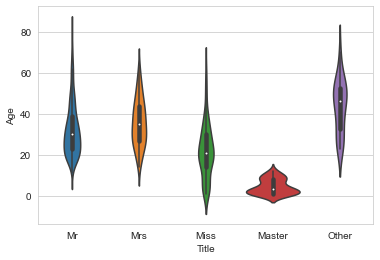

In [20]:
sns.violinplot(data=df_train, x="Title", y="Age")
plt.show()

That looks pretty good. We can use Title variable to classify the age of the passengers. Let's check passenger's average age based on their title.



In [21]:
df_train.groupby('Title')['Age'].mean()


Title
Master     4.574167
Miss      21.816327
Mr        32.368090
Mrs       35.788991
Other     43.750000
Name: Age, dtype: float64

Fill in the missing age value using the average passenger age for each title.

In [22]:
data = [df_train, df_test]
for df in data:
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Master'), 'Age'] = 5
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Miss'), 'Age'] = 22
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Mr'), 'Age'] = 32
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Mrs'), 'Age'] = 36
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Other'), 'Age'] = 44

We know that Fare variable in test data has missing value, so we will try to impute that variable value based on train data. Let's check the correlation Fare variable with other variables.



In [23]:
df_train.corr()["Fare"].sort_values(ascending=False)


Fare        1.000000
Survived    0.257307
Parch       0.216225
SibSp       0.159651
Age         0.092122
Pclass     -0.549500
Name: Fare, dtype: float64

As we can see, Pclass variable has a relatively strong negative correlation with Fare variable. So, we will use the mean value of Fare based on the Pclass variable to fill in the missing values.



In [24]:
df_test[df_test["Fare"].isna()]


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,3,male,60.5,0,0,NaN,S,Mr


Passenger with missing fare has Pclass = 3.



In [25]:
df_test.Fare.fillna(df_train.groupby("Pclass").mean()["Fare"][3], inplace=True)

We can create a new variable that shows the number of families accompanying their trip by adding up the values of the SibSp and Parch variables. And then from these variables, we can also create a variable that indicates whether the passenger is alone or not.



In [26]:
data = [df_train, df_test]
for df in data:
    df['Relatives'] = df['SibSp'] + df['Parch']
    df.loc[df['Relatives'] > 0, 'Alone'] = 1
    df.loc[df['Relatives'] == 0, 'Alone'] = 0

We can remove SIbSp and Parch variables since we don't need them anymore.



In [27]:
df_train.drop(["SibSp", "Parch"], axis=1, inplace=True)
df_test.drop(["SibSp", "Parch"], axis=1, inplace=True)

Some variables like Sex, Embarked, and Title are categorical, so we need to encode them first so that it can be used into machine learning models.

In [28]:
df_train = pd.get_dummies(df_train, prefix=["Sex", "Embarked", "Title"])
df_test = pd.get_dummies(df_test, prefix=["Sex", "Embarked", "Title"])

## 4. Model Building

In [29]:
# Splitting Dataset
X_train = df_train.drop("Survived", axis=1)
y_train = df_train.Survived

X_test = df_test.copy()

In [30]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Choosing Best Algorithm
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train_scaled, y_train, cv=10,
        scoring=(['accuracy', 'f1'])
    )

    results = results.append({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
        "Avg_F1_Score": cv_results['test_f1'].mean()
    }, ignore_index=True)
    
results["Avg_Overall"] = (results["Avg_Accuracy"] + results["Avg_F1_Score"]) / 2
results = results.sort_values("Avg_Overall", ascending=False)
results

,Classifier,Avg_Accuracy,Avg_F1_Score,Avg_Overall
1,LR,0.830537,0.769458,0.799997
5,MLP,0.826092,0.753199,0.789646
4,SVM,0.822697,0.747500,0.785098
0,KNN,0.819388,0.745880,0.782634
6,XGB,0.810375,0.745315,0.777845
3,RF,0.809238,0.743213,0.776226
2,DT,0.785668,0.717482,0.751575


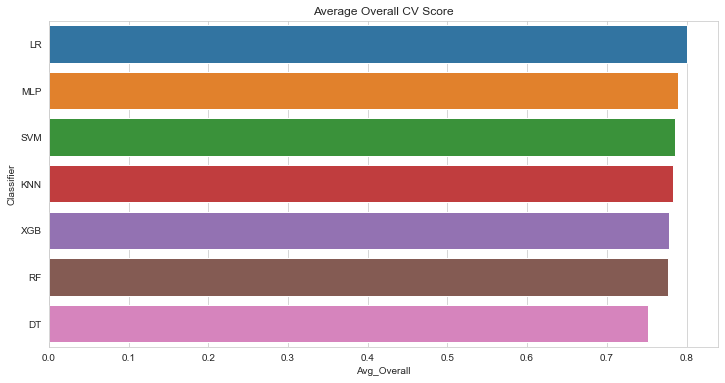

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x="Avg_Overall", y="Classifier")
plt.title("Average Overall CV Score")
plt.show()

Looks like Logistic Regression is our best model here. We will use this algorithm to predict the test data. But before that, we will adjust the hyperparameters on this algorithm using Grid Search Cross Validation.



In [33]:
# Hyperparameter Tuning
lr = LogisticRegression()
params = {
    "penalty": ("l1", "l2", "elasticnet"),
    "tol": (0.1, 0.01, 0.001, 0.0001),
    "C": (10.0, 1.0, 0.1, 0.01)
}
clf = GridSearchCV(lr, params, cv=10)
clf.fit(X_train_scaled, y_train)
print("Best hyperparameter:", clf.best_params_)

Best hyperparameter: {'C': 1.0, 'penalty': 'l2', 'tol': 0.1}


/Users/andrusyakmd/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
320 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andrusyakmd/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andrusyakmd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/andrusyakmd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear

Train Accuracy: 0.8338945005611672
Train F1-Score: 0.7771084337349397


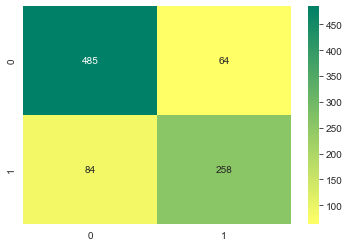

In [34]:
y_pred = clf.predict(X_train_scaled)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Train F1-Score: {f1_score(y_train, y_pred)}")
sns.heatmap(confusion_matrix(y_train, y_pred), fmt='.3g', annot=True, cmap='summer_r')
plt.show()

In [35]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.88      0.87       549
           1       0.80      0.75      0.78       342

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



In [36]:
y_pred = clf.predict(X_test_scaled)

submission = pd.read_csv("gender_submission.csv")
submission["Survived"] = y_pred
print(accuracy_score(submission["Survived"], y_pred))

1.0


In [37]:
submission.to_csv('submission.csv', index=False)